# 人工神经网络基础

### 杜小勤，武汉纺织大学数学与计算机学院
https://duxiaoqin.github.io/

适用版本Python 3。本演示程序改编自https://github.com/mnielsen/neural-networks-and-deep-learning

所需数据文件"mnist.pkl.gz"(~16MB)，请从https://github.com/mnielsen/neural-networks-and-deep-learning/tree/master/data
处下载。

In [1]:
import numpy as np
import pickle
import gzip

In [2]:
def load_data():
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding = 'bytes')
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (list(training_data), list(validation_data), list(test_data))

def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

载入手写体数字数据集

In [3]:
training_data, validation_data, test_data = load_data_wrapper()

In [4]:
print(len(training_data))
print(len(validation_data))
print(len(test_data))
print(training_data[0][0].shape)
print(validation_data[0][0].shape)
print(test_data[0][0].shape)

50000
10000
10000
(784, 1)
(784, 1)
(784, 1)


In [5]:
#training_data的标签数据与validation_data和test_data的标签数据，格式不一样。方便结果的验证
print(training_data[0][1])
print(validation_data[0][1])
print(test_data[0][1])

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
3
7


显示手写体数字图像

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

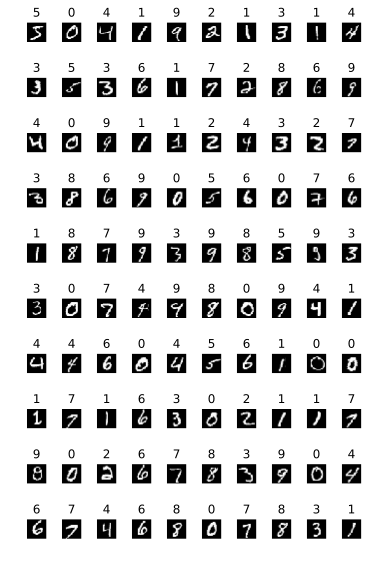

In [7]:
plt.figure(figsize=(6, 10))
plt.subplots_adjust(wspace = 0.8)
for row in range(10):
    for col in range(10):
        plt.subplot(10, 10, row * 10 + col + 1), plt.title(np.argmax(training_data[row * 10 + col][1]))
        plt.imshow(training_data[row * 10 + col][0].reshape(28, 28), cmap = 'gray'), plt.axis('off')

In [8]:
class Network():
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
    def sigmoid(self, z):
        return 1.0/(1.0 + np.exp(-z))

    def sigmoid_prime(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a) + b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, validation_data = None, test_data = None):
        train_acc, val_acc, test_acc = [], [], []
        n_train = len(training_data)
        train_eval = self.evaluate(training_data, index = False) / n_train
        train_acc.append(train_eval)
        print('Before training:\n***train acc = {0}%'.format(train_eval * 100))
        if validation_data:
            n_valid = len(validation_data)
            val_eval = self.evaluate(validation_data) / n_valid
            val_acc.append(val_eval)
            print('***validation acc = {0}%'.format(val_eval * 100))
        if test_data: 
            n_test = len(test_data)
            test_eval = self.evaluate(test_data) / n_test
            test_acc.append(test_eval)
            print("***test acc = {0}%".format(test_eval * 100))
        for j in range(epochs):
            np.random.shuffle(training_data)
            mini_batches = [training_data[k : k + mini_batch_size] for k in range(0, n_train, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            train_eval = self.evaluate(training_data, index = False) / n_train
            train_acc.append(train_eval)
            print('Epoch {0}:\n***train acc = {1}%'.format(j + 1, train_eval * 100))
            if validation_data:
                val_eval = self.evaluate(validation_data) / n_valid
                val_acc.append(val_eval)
                print('***validation acc = {0}%'.format(val_eval * 100))
            if test_data: 
                test_eval = self.evaluate(test_data) / n_test
                test_acc.append(test_eval)
                print("***test acc = {0}%".format(test_eval * 100))
        return train_acc, val_acc, test_acc
                
    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w - (eta / len(mini_batch)) * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * self.sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    def evaluate(self, data, index = True):
        if index == True:
            test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in data]
        else:
            test_results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]
        return sum(int(x == y) for (x, y) in test_results)
    
    def cost_derivative(self, output_activations, y):
        return (output_activations - y)

开始训练神经网络

In [9]:
network = Network([784, 30, 10])
train_acc, val_acc, test_acc = network.SGD(training_data, 30, 10, 3.0, validation_data = None, test_data = test_data)

Before training:
***train acc = 15.112%
***test acc = 15.78%
Epoch 1:
***train acc = 90.98%
***test acc = 91.19%
Epoch 2:
***train acc = 92.914%
***test acc = 92.54%
Epoch 3:
***train acc = 93.76400000000001%
***test acc = 93.03%
Epoch 4:
***train acc = 94.174%
***test acc = 93.43%
Epoch 5:
***train acc = 94.94%
***test acc = 94.07%
Epoch 6:
***train acc = 95.13000000000001%
***test acc = 94.13%
Epoch 7:
***train acc = 95.212%
***test acc = 94.03%
Epoch 8:
***train acc = 95.048%
***test acc = 93.74%
Epoch 9:
***train acc = 95.60600000000001%
***test acc = 94.49%
Epoch 10:
***train acc = 95.488%
***test acc = 94.24%
Epoch 11:
***train acc = 95.794%
***test acc = 94.73%
Epoch 12:
***train acc = 95.89%
***test acc = 94.46%
Epoch 13:
***train acc = 96.22%
***test acc = 94.6%
Epoch 14:
***train acc = 96.03399999999999%
***test acc = 94.45%
Epoch 15:
***train acc = 96.25399999999999%
***test acc = 94.38%
Epoch 16:
***train acc = 96.312%
***test acc = 94.82000000000001%
Epoch 17:
***train acc

绘制训练曲线

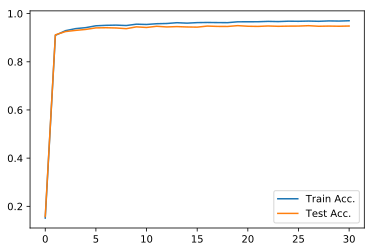

In [10]:
if len(train_acc) != 0:
    plt.plot(train_acc, label = 'Train Acc.')
if len(val_acc) != 0:
    plt.plot(val_acc, label = 'Validation Acc.')
if len(test_acc) != 0:
    plt.plot(test_acc, label = 'Test Acc.')
plt.legend()
plt.show()

参考文献：
- https://github.com/mnielsen/neural-networks-and-deep-learning;